<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Using Google Colab with GitHub

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

import torchvision
import torch
from torch.utils.data import DataLoader

In [22]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor
from loader import WaldoLoader
from model import Waldo_model
from training import train_model

In [10]:
path_dataset_folder = "../dataset"
path_image_folder = "images"
fname_annotation = "annotations.csv"
extension = ".jpg"
ratio_train_valid_dataset = 0.6
ratio_valid_dataset = 0.2
int_seed_split = 7109
size_patch = 240
sequence_data_augmentation = None #Sequence([RandomTranslate(0.2)]) #RandomHorizontalFlip(0.5)]) #, RandomTranslate(0.2)])
size_batch = 16

In [11]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the dataset...".format(len(list_fname_im)))

Found 29 images in the dataset...


In [12]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.head())

Getting annotations...
  filename  width  height  class  xmin  ymin  xmax  ymax
0  001.jpg   2048    1251  waldo   706   513   743   562
1  002.jpg   1286     946  waldo    82   521   107   554
2  003.jpg   2048    1346  waldo  1390   463  1422   500
3  004.jpg   2048    1272  waldo  1484   279  1507   306
4  005.jpg   2100    1760  waldo   882   594   913   634


In [13]:
print("Saving binary mask from annotations as ground-truth...")
for index, row in df_annotations.iterrows():
    fname_im = row["filename"]
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        mask = create_binary_mask(bbox_coords=row[["xmin", "ymin", "xmax", "ymax"]],
                              im_ref_width=row["width"],
                              im_ref_height=row["height"])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...


<IPython.core.display.Javascript object>


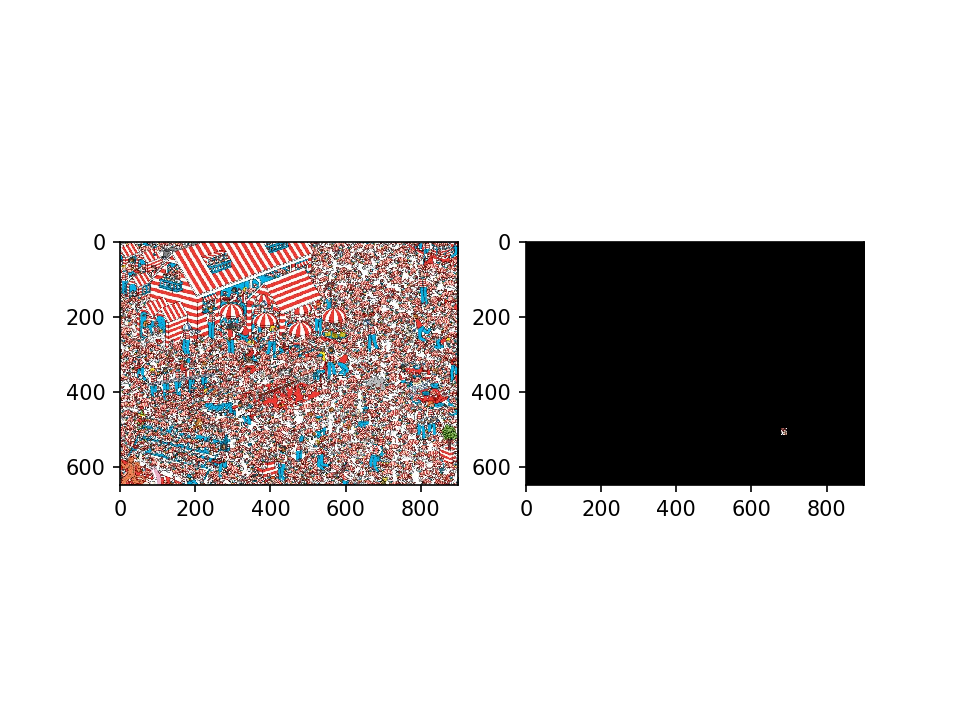

In [14]:
fig = plt.figure()

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
mask = create_binary_mask(bbox_coords=row[["xmin", "ymin", "xmax", "ymax"]],
                      im_ref_width=row["width"],
                      im_ref_height=row["height"])
np_im[np.where(mask == 0)] = 0
plt.imshow(np_im)

plt.show()

In [15]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate, df_fname_test = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split),
             [int(ratio_train_valid_dataset*len(df_fname)),
              int((1-ratio_valid_dataset)*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"
df_annotations.loc[df_annotations["filename"].isin(df_fname_test), "subset"] = "testing"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554  validation
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306     testing
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [16]:
width_largest = df_annotations["width"].max()
height_ = df_annotations[df_annotations["width"] == width_largest]["height"].tolist()[0]
size_img = (width_largest, height_)

In [17]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"]
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Resizing all images to same dimensions: (2953, 2088) pixels^2 ...
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)
(240, 240, 3)
(240, 240)


In [18]:
len(dataset_train)

2106

In [19]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)

In [21]:
#image_expl, label_expl = iter(loader_train).next()
#print(image_expl.mean(), image_expl.std())
#print(label_expl.unique(), label_expl.size(), image_expl.size())

(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 7
(3, 240, 240) (240, 240) [0. 1.] 1
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 9
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 3
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 1
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 0
(3, 240, 240) (240, 240) [0. 1.] 9
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 9
tensor(2.2683e-09) tensor(1.0000)
tensor([  0., 120., 153., 166., 171., 173., 175., 176., 178., 183., 194., 202.]) torch.Size([16, 4]) torch.Size([16, 3, 240, 240])


In [23]:
model = Waldo_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
train_model(model, optimizer, loader_train, dataset_validation=None, n_epoch=15)